In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random

# 5월 27일 프로야구 NC 다이노스 VS SSG 랜더스 승부예측

In [2]:
# cp949 인코딩 사용
nc_summary = pd.read_csv("NC 타자 종합 data.csv", encoding='cp949')
nc_outcount = pd.read_csv("NC 타자 아웃카운트별 data.csv", encoding='cp949')
nc_runner = pd.read_csv("NC 타자 주자 위치별 data.csv", encoding='cp949')
nc_count = pd.read_csv("NC 타자 카운트별 data.csv", encoding='cp949')

ssg_summary = pd.read_csv("SSG 타자 종합 data.csv", encoding='cp949')
ssg_outcount = pd.read_csv("SSG 타자 아웃카운트별 data.csv", encoding='cp949')
ssg_runner = pd.read_csv("SSG 타자 주자 위치별 data.csv", encoding='cp949')
ssg_count = pd.read_csv("SSG 타자 카운트별 data.csv", encoding='cp949')

따로 제작해야 하는 상대투수별 DATA는 대부분이 결측치라 활용하지 않았습니다.

In [3]:
nc_summary.head()

,타자 정보,타율,안타,2루타,3루타,홈런,타점,득점,희생번트,희생플라이,볼넷,삼진,장타율,출루율,OPS
0,박민우,0.292,31,10,2,0,13,18,1,0,10,18,0.425,0.375,0.800
1,손아섭,0.367,40,6,3,0,20,13,0,1,14,15,0.477,0.435,0.912
2,박건우,0.368,14,5,0,0,7,3,0,2,5,4,0.500,0.422,0.922
3,데이비슨,0.314,27,5,0,7,21,16,0,4,8,24,0.616,0.370,0.986
4,권희동,0.261,24,7,0,2,7,15,1,0,20,16,0.402,0.429,0.831


### 결측치 유무 확인 후 결측치들을 각 칼럼의 중앙값으로 대체

In [4]:
nc_summary.isnull().sum()

타자 정보    0
타율       0
안타       0
2루타      0
3루타      0
홈런       0
타점       0
득점       0
희생번트     0
희생플라이    0
볼넷       0
삼진       0
장타율      0
출루율      0
OPS      0
dtype: int64

In [5]:
nc_outcount.isnull().sum()

아웃카운트에 따른 타율    0
0 OUT           0
1 OUT           0
2 OUT           0
dtype: int64

In [6]:
nc_runner.isnull().sum()

주자 위치에 따른 타율    0
1루              0
2루              0
3루              0
1루,2루           0
1루,3루           3
2루,3루           1
만루              0
dtype: int64

In [7]:
nc_runner['1루,3루'] = nc_runner['1루,3루'].fillna(nc_runner['1루,3루'].median())
nc_runner['2루,3루'] = nc_runner['2루,3루'].fillna(nc_runner['2루,3루'].median())

In [8]:
nc_runner.isnull().sum()

주자 위치에 따른 타율    0
1루              0
2루              0
3루              0
1루,2루           0
1루,3루           0
2루,3루           0
만루              0
dtype: int64

In [9]:
nc_count.isnull().sum()

카운트에 따른 타자 타율     0
0S 0B             0
1S                0
2S                0
1S 1B             0
1S 2B             0
1S 3B             4
2S 1B             0
2S 2B             0
2S 3B             0
1B                0
2B                3
3B               10
dtype: int64

In [10]:
nc_count['3B'].values

array([nan, nan, nan, nan, nan, nan, nan,  0., nan, nan, nan])

3B에 대한 결측치들을 0으로 대체

In [11]:
nc_count['1S 3B'] = nc_count['1S 3B'].fillna(nc_count['1S 3B'].median())
nc_count['2B'] = nc_count['2B'].fillna(nc_count['2B'].median())
nc_count['3B'] = nc_count['3B'].fillna(0)

In [12]:
nc_count.isnull().sum()

카운트에 따른 타자 타율    0
0S 0B            0
1S               0
2S               0
1S 1B            0
1S 2B            0
1S 3B            0
2S 1B            0
2S 2B            0
2S 3B            0
1B               0
2B               0
3B               0
dtype: int64

In [13]:
nc_count['3B'].values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
ssg_summary.isnull().sum()

타자 정보    0
타율       0
안타       0
2루타      0
3루타      0
홈런       0
타점       0
득점       0
희생번트     0
희생플라이    0
볼넷       0
삼진       0
장타율      0
출루율      0
OPS      0
dtype: int64

In [15]:
ssg_outcount.isnull().sum()

아웃카운트에 따른 타율    34
0 OUT           34
1 OUT           34
2 OUT           34
dtype: int64

In [16]:
ssg_runner.isnull().sum()

주자 위치에 따른 타율    0
1루              0
2루              0
3루              1
1루,2루           0
1루,3루           3
2루,3루           3
만루              1
dtype: int64

In [17]:
ssg_runner['3루'] = ssg_runner['3루'].fillna(ssg_runner['3루'].median())
ssg_runner['1루,3루'] = ssg_runner['1루,3루'].fillna(ssg_runner['1루,3루'].median())
ssg_runner['2루,3루'] = ssg_runner['2루,3루'].fillna(ssg_runner['2루,3루'].median())
ssg_runner['만루'] = ssg_runner['만루'].fillna(ssg_runner['만루'].median())

In [18]:
ssg_runner.isnull().sum()

주자 위치에 따른 타율    0
1루              0
2루              0
3루              0
1루,2루           0
1루,3루           0
2루,3루           0
만루              0
dtype: int64

In [19]:
ssg_count.isnull().sum()

카운트에 따른 타자 타율     0
0S 0B             0
1S                0
2S                0
1S 1B             0
1S 2B             1
1S 3B             2
2S 1B             0
2S 2B             0
2S 3B             0
1B                0
2B                0
3B               11
dtype: int64

In [20]:
ssg_count['1S 2B'] = ssg_count['1S 2B'].fillna(ssg_count['1S 2B'].median())
ssg_count['1S 3B'] = ssg_count['1S 3B'].fillna(ssg_count['1S 3B'].median())
ssg_count['3B'] = ssg_count['3B'].fillna(0)

In [21]:
ssg_count.isnull().sum()

카운트에 따른 타자 타율    0
0S 0B            0
1S               0
2S               0
1S 1B            0
1S 2B            0
1S 3B            0
2S 1B            0
2S 2B            0
2S 3B            0
1B               0
2B               0
3B               0
dtype: int64

# 타순 짜기

In [22]:
nc_summary['점수'] = (nc_summary['타율'] * 0.3) + (nc_summary['OPS'] * 0.7)
nc타순 = nc_summary.sort_values(by='점수', ascending=False)
nc타순

,타자 정보,타율,안타,2루타,3루타,홈런,타점,득점,희생번트,희생플라이,볼넷,삼진,장타율,출루율,OPS,점수
3,데이비슨,0.314,27,5,0,7,21,16,0,4,8,24,0.616,0.370,0.986,0.7844
2,박건우,0.368,14,5,0,0,7,3,0,2,5,4,0.500,0.422,0.922,0.7558
1,손아섭,0.367,40,6,3,0,20,13,0,1,14,15,0.477,0.435,0.912,0.7485
7,김형준,0.258,24,3,1,9,26,14,1,1,10,33,0.602,0.327,0.929,0.7277
4,권희동,0.261,24,7,0,2,7,15,1,0,20,16,0.402,0.429,0.831,0.6600
0,박민우,0.292,31,10,2,0,13,18,1,0,10,18,0.425,0.375,0.800,0.6476
9,한석현,0.265,9,1,0,1,10,9,4,1,6,4,0.382,0.422,0.804,0.6423
5,서호철,0.303,20,3,0,1,9,5,4,1,4,10,0.394,0.347,0.741,0.6096
10,박시원,0.211,8,2,0,1,1,10,1,0,5,12,0.342,0.302,0.644,0.5141
8,김주원,0.216,27,4,1,3,15,21,3,1,14,29,0.336,0.298,0.634,0.5086


In [23]:
nc_lineup = nc타순.head(9)['타자 정보'].reset_index(drop=True).tolist()
nc_lineup

['데이비슨', '박건우', '손아섭', '김형준', '권희동', '박민우', '한석현', '서호철', '박시원']

In [24]:
ssg_summary['점수'] = (ssg_summary['타율'] * 0.3) + (ssg_summary['OPS'] * 0.7)
ssg타순 = ssg_summary.sort_values(by='점수', ascending=False)
ssg타순

,타자 정보,타율,안타,2루타,3루타,홈런,타점,득점,희생번트,희생플라이,볼넷,삼진,장타율,출루율,OPS,점수
2,최정,0.292,7,0,0,4,8,5,0,0,3,4,0.792,0.393,1.185,0.9171
0,최지훈,0.333,48,7,0,2,14,21,1,3,13,22,0.424,0.385,0.809,0.6662
3,에레디아,0.313,15,0,0,1,6,6,0,1,7,8,0.375,0.404,0.779,0.6392
6,최준우,0.216,11,0,0,2,11,8,2,2,13,18,0.333,0.382,0.715,0.5653
5,고명준,0.264,34,8,0,2,16,7,0,1,8,35,0.372,0.309,0.681,0.5559
8,조형우,0.254,15,0,0,2,6,5,1,0,3,10,0.356,0.302,0.658,0.5368
4,한유섬,0.244,31,9,0,1,11,14,1,0,13,35,0.339,0.314,0.653,0.5303
7,김성현,0.239,16,2,0,1,5,10,3,0,9,10,0.313,0.329,0.642,0.5211
1,박성한,0.195,24,7,0,2,15,13,1,0,21,29,0.301,0.317,0.618,0.4911
9,오태곤,0.165,14,4,0,1,10,8,3,0,12,26,0.247,0.276,0.523,0.4156


In [25]:
ssg_lineup = ssg타순.head(9)['타자 정보'].reset_index(drop=True).tolist()
ssg_lineup

['최정', '최지훈', '에레디아', '최준우', '고명준', '조형우', '한유섬', '김성현', '박성한']

In [26]:
# 1. 타자 이름 컬럼명을 모두 "타자명"으로 통일
nc_summary = nc_summary.rename(columns={'타자 정보': '타자명'})
nc_outcount = nc_outcount.rename(columns={'아웃카운트에 따른 타율': '타자명'})
nc_runner = nc_runner.rename(columns={'주자 위치에 따른 타율': '타자명'})
nc_count = nc_count.rename(columns={'카운트에 따른 타자 타율': '타자명'})

# 2. 병합 (left join으로 순차 병합)
nc_merged = nc_summary.merge(nc_outcount, on='타자명', how='left')
nc_merged = nc_merged.merge(nc_runner, on='타자명', how='left')
nc_merged = nc_merged.merge(nc_count, on='타자명', how='left')


In [27]:
nc_merged

,타자명,타율,안타,2루타,3루타,홈런,타점,득점,희생번트,희생플라이,...,2S,1S 1B,1S 2B,1S 3B,2S 1B,2S 2B,2S 3B,1B,2B,3B
0,박민우,0.292,31,10,2,0,13,18,1,0,...,0.111,0.182,0.400,0.000,0.111,0.077,0.429,0.500,1.000,0.0
1,손아섭,0.367,40,6,3,0,20,13,0,1,...,0.375,0.231,0.571,0.500,0.381,0.250,0.222,0.556,0.333,0.0
2,박건우,0.368,14,5,0,0,7,3,0,2,...,0.000,0.167,1.000,1.000,0.400,0.333,0.600,0.000,0.100,0.0
3,데이비슨,0.314,27,5,0,7,21,16,0,4,...,0.167,0.571,0.500,0.667,0.176,0.286,0.200,0.444,0.200,0.0
4,권희동,0.261,24,7,0,2,7,15,1,0,...,0.125,0.083,0.750,0.000,0.211,0.176,0.333,1.000,0.100,0.0
5,서호철,0.303,20,3,0,1,9,5,4,1,...,0.000,0.500,0.000,0.000,0.231,0.250,0.250,0.375,0.000,0.0
6,김휘집,0.192,19,5,0,3,9,13,1,0,...,0.000,0.333,0.500,0.000,0.083,0.063,0.333,0.200,0.333,0.0
7,김형준,0.258,24,3,1,9,26,14,1,1,...,0.143,0.833,0.333,0.000,0.182,0.077,0.222,0.500,0.000,0.0
8,김주원,0.216,27,4,1,3,15,21,3,1,...,0.125,0.333,0.200,0.000,0.147,0.333,0.000,0.333,0.000,0.0
9,한석현,0.265,9,1,0,1,10,9,4,1,...,0.000,0.667,0.333,0.000,0.333,0.250,0.500,0.500,0.100,0.0


In [28]:
# 1. 타자 이름 컬럼명을 모두 "타자명"으로 통일
ssg_summary = ssg_summary.rename(columns={'타자 정보': '타자명'})
ssg_outcount = ssg_outcount.rename(columns={'아웃카운트에 따른 타율': '타자명'})
sg_runner = ssg_runner.rename(columns={'주자 위치에 따른 타율': '타자명'})
ssg_count = ssg_count.rename(columns={'카운트에 따른 타자 타율': '타자명'})

# 2. 병합 (left join으로 순차 병합)
ssg_merged = ssg_summary.merge(nc_outcount, on='타자명', how='left')
ssg_merged = ssg_merged.merge(nc_runner, on='타자명', how='left')
ssg_merged = ssg_merged.merge(nc_count, on='타자명', how='left')

In [29]:
ssg_merged

,타자명,타율,안타,2루타,3루타,홈런,타점,득점,희생번트,희생플라이,...,2S,1S 1B,1S 2B,1S 3B,2S 1B,2S 2B,2S 3B,1B,2B,3B
0,최지훈,0.333,48,7,0,2,14,21,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,박성한,0.195,24,7,0,2,15,13,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,최정,0.292,7,0,0,4,8,5,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,에레디아,0.313,15,0,0,1,6,6,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,한유섬,0.244,31,9,0,1,11,14,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,고명준,0.264,34,8,0,2,16,7,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,최준우,0.216,11,0,0,2,11,8,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,김성현,0.239,16,2,0,1,5,10,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,조형우,0.254,15,0,0,2,6,5,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,오태곤,0.165,14,4,0,1,10,8,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
def compute_player_hit_probs(df):

    # 타율과 OPS의 최소, 최대 값 계산합니다.
    avg_min, avg_max = df['타율'].min(), df['타율'].max()
    ops_min, ops_max = df['OPS'].min(), df['OPS'].max()

    player_probs = {}

    for idx, row in df.iterrows():
        pa = estimate_at_bats(row)
        total_hits = row['안타']

        if pa == 0 or total_hits == 0 or pd.isna(row['타율']) or pd.isna(row['OPS']):
            probs = {'1B': 0, '2B': 0, '3B': 0, 'HR': 0, 'OUT': 1.0}
            
        else:
            avg_range = max(0.001, avg_max - avg_min)
            ops_range = max(0.001, ops_max - ops_min)

            avg_norm = (row['타율'] - avg_min) / avg_range
            ops_norm = (row['OPS'] - ops_min) / ops_range

            # 선수별 안타칠 확률을 계산합니다. (0.1~0.3 사이로 설정)
            # 이 값들을 자유롭게 변경하셔서 실제 결과와 비슷한 parameter가 무엇일지 찾아보면 좋을 것 같습니다!
            
            # 저는 지금 타율을 0.3, ops를 0.7 가중치로 두었고, 안타칠 확률은 최소 0.1, 최대 0.3으로 설정했습니다.
            
            prob_hit = 0.1 + 0.2 * (0.3 * avg_norm + 0.7 * ops_norm)
            prob_out = 1 - prob_hit

            # 각 선수별 안타, 2루타, 3루타, 홈런칠 확률 생성합니다. (이것도 0.01, 0.005 숫자를 자유롭게 변경 하시면 됩니다.)
            prob_1B = max(0.01, row['1B'] / total_hits)
            prob_2B = max(0.005, row['2B'] / total_hits)
            prob_3B = max(0.002, row['3B'] / total_hits)
            prob_HR = max(0.005, row['홈런'] / total_hits)

            total_ratio = prob_1B + prob_2B + prob_3B + prob_HR
            prob_1B /= total_ratio
            prob_2B /= total_ratio
            prob_3B /= total_ratio
            prob_HR /= total_ratio
            
            probs = {
                '1B': prob_hit * prob_1B,
                '2B': prob_hit * prob_2B,
                '3B': prob_hit * prob_3B,
                'HR': prob_hit * prob_HR,
                'OUT': prob_out
            }

            total_prob = sum(probs.values())
            if total_prob > 0:
                for k in probs:
                    probs[k] /= total_prob

        player_probs[row['타자명']] = probs

    return player_probs

In [31]:
def estimate_at_bats(row):
    sac = row.get('희생번트', 0)
    sf = row.get('희생플라이', 0)
    if row['타율'] > 0:
        est_pa = row['안타'] / row['타율']
    else:
        est_pa = 100 
    est_pa -= sac + sf
    return max(1, est_pa)

In [32]:
def simulate_at_bat(player_name, player_probs):
    probs = player_probs[player_name]
    return random.choices(list(probs.keys()), weights=list(probs.values()), k=1)[0]

In [33]:
def update_bases(base_state, result):
    runs = 0
    new_bases = [0, 0, 0]

    if result == 'OUT':
        return base_state, runs

    if result == 'HR':
        runs = sum(base_state) + 1
        return [0, 0, 0], runs

    if result == '1B':
        runs += base_state[2]
        new_bases[2] = base_state[1]
        new_bases[1] = base_state[0]
        new_bases[0] = 1
    elif result == '2B':
        runs += base_state[2] + base_state[1]
        new_bases[2] = base_state[0]
        new_bases[1] = 1
    elif result == '3B':
        runs += sum(base_state)
        new_bases[2] = 1

    return new_bases, runs

In [34]:
def simulate_half_inning(lineup, player_probs, start_idx):
    outs = 0
    bases = [0, 0, 0]
    score = 0
    batter_idx = start_idx
    batter_stats = {name: {'타수': 0, '안타': 0} for name in lineup}

    while outs < 3:
        batter = lineup[batter_idx % len(lineup)]
        result = simulate_at_bat(batter, player_probs)
        batter_stats[batter]['타수'] += 1
        if result != 'OUT':
            batter_stats[batter]['안타'] += 1
        bases, runs = update_bases(bases, result)
        score += runs
        if result == 'OUT':
            outs += 1
        batter_idx += 1

    return score, batter_idx, batter_stats

In [38]:
def simulate_game(away_lineup, away_probs, home_lineup, home_probs):
    away_idx, home_idx = 0, 0
    away_scores, home_scores = [], []
    away_stats_total = {name: {'타수': 0, '안타': 0} for name in away_lineup}
    home_stats_total = {name: {'타수': 0, '안타': 0} for name in home_lineup}

    for inning in range(9):
        away_score, away_idx, away_stats = simulate_half_inning(away_lineup, away_probs, away_idx)
        for name in away_stats:
            away_stats_total[name]['타수'] += away_stats[name]['타수']
            away_stats_total[name]['안타'] += away_stats[name]['안타']
        away_scores.append(away_score)

        # 홈팀이 이기고 있는경우, 9회말은 진행하지 않습니다.
        
        if inning == 8 and sum(home_scores) > sum(away_scores):
            break

        home_score, home_idx, home_stats = simulate_half_inning(home_lineup, home_probs, home_idx)
        for name in home_stats:
            home_stats_total[name]['타수'] += home_stats[name]['타수']
            home_stats_total[name]['안타'] += home_stats[name]['안타']
        home_scores.append(home_score)

    return {
        'away_total': sum(away_scores),
        'home_total': sum(home_scores),
        'away_inning_scores': away_scores,
        'home_inning_scores': home_scores,
        'away_stats': away_stats_total,
        'home_stats': home_stats_total
    }

In [39]:
def plot_inning_scores(team_name, scores):
    innings = list(range(1, len(scores)+1))
    plt.plot(innings, scores, marker='o', label=team_name)
    plt.xticks(range(1, 10))
    plt.xlabel("이닝")
    plt.ylabel("득점")
    plt.title("이닝별 득점")
    plt.legend()
    plt.grid(True)

In [40]:
nc_player_probs = compute_player_hit_probs(nc_merged)
ssg_player_probs = compute_player_hit_probs(ssg_merged)

In [41]:
result = simulate_game(
    away_lineup=nc_lineup,
    away_probs=nc_player_probs,
    home_lineup=ssg_lineup,
    home_probs=ssg_player_probs
)

In [42]:
print(f"nc(원정): {result['away_total']}점")
print(f"ssg(홈): {result['home_total']}점")

nc(원정): 6점
ssg(홈): 7점


c:\users\user\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 46301 (\N{HANGUL SYLLABLE DEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 45789 (\N{HANGUL SYLLABLE NING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\IPython\

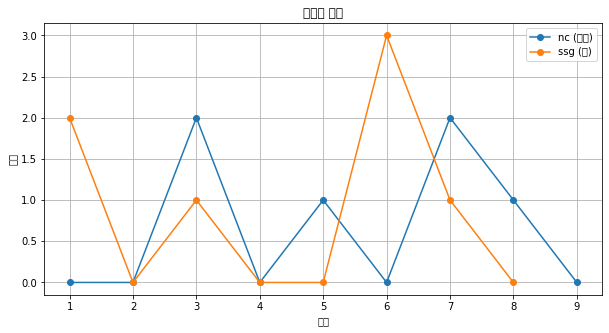

In [43]:
plt.figure(figsize=(10, 5))
plot_inning_scores("nc (원정)", result['away_inning_scores'])
plot_inning_scores("ssg (홈)", result['home_inning_scores'])
plt.show()

# 타자별 하루 결과를 나타내는 함수

In [44]:
def print_player_stats(team_name, stats_dict):
    print(f"\n📊 {team_name} 타자 성적")
    print("-" * 30)
    for player, stats in stats_dict.items():
        ab = stats['타수']
        hits = stats['안타']
        avg = hits / ab if ab > 0 else 0
        print(f"{player}: {ab}타수 {hits}안타 ({avg:.3f})")


In [45]:
print_player_stats("nc", result['away_stats'])
print_player_stats("ssg", result['home_stats'])


📊 nc 타자 성적
------------------------------
데이비슨: 4타수 1안타 (0.250)
박건우: 4타수 0안타 (0.000)
손아섭: 4타수 1안타 (0.250)
김형준: 4타수 0안타 (0.000)
권희동: 4타수 0안타 (0.000)
박민우: 4타수 1안타 (0.250)
한석현: 4타수 2안타 (0.500)
서호철: 3타수 1안타 (0.333)
박시원: 3타수 1안타 (0.333)

📊 ssg 타자 성적
------------------------------
최정: 4타수 2안타 (0.500)
최지훈: 4타수 2안타 (0.500)
에레디아: 4타수 1안타 (0.250)
최준우: 4타수 1안타 (0.250)
고명준: 4타수 1안타 (0.250)
조형우: 3타수 0안타 (0.000)
한유섬: 3타수 1안타 (0.333)
김성현: 3타수 0안타 (0.000)
박성한: 3타수 0안타 (0.000)


## 몬테카를로 알고리즘을 활용해서 경기수를 N번 반복했을 때의 평균 점수 및 승률을 예측해보기

In [46]:
def simulate_game_monte_carlo(n_simulations, away_lineup, away_probs, home_lineup, home_probs):
    results = []
    for _ in range(n_simulations):
        game_result = simulate_game(away_lineup, away_probs, home_lineup, home_probs)
        results.append(game_result)
    return results

In [47]:
def summarize_results(results):
    away_total = [r['away_total'] for r in results]
    home_total = [r['home_total'] for r in results]
    print(f"평균 점수 (AWAY): {sum(away_total)/len(away_total):.2f}")
    print(f"평균 점수 (HOME): {sum(home_total)/len(home_total):.2f}")
    print(f"승률 (AWAY): {sum(1 for i in range(len(results)) if away_total[i] > home_total[i]) / len(results):.2%}")
    print(f"승률 (HOME): {sum(1 for i in range(len(results)) if home_total[i] > away_total[i]) / len(results):.2%}")

In [56]:
nc_player_probs = compute_player_hit_probs(nc_merged)
ssg_player_probs = compute_player_hit_probs(ssg_merged)

## 400번 시행했을 때의 결과 비교

In [63]:
monte_results = simulate_game_monte_carlo(
    n_simulations=400,
    away_lineup=nc_lineup,
    away_probs=nc_player_probs,
    home_lineup=ssg_lineup,
    home_probs=ssg_player_probs
)

In [64]:
summarize_results(monte_results)

평균 점수 (AWAY): 5.16
평균 점수 (HOME): 5.21
승률 (AWAY): 39.50%
승률 (HOME): 51.75%
